In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [106]:
im = Image.open('test_input.png')
im_mat = np.array(im)
print(im_mat)
print(im_mat.shape)

an = Image.open('test_seman.png')
an_mat = np.array(an)
print(an_mat)
print(an_mat.shape)

dep = Image.open('test_depth.png')
dep_mat = np.array(dep)
print(dep_mat)
print(dep_mat.shape)


[[29 27 28 ... 40 40 40]
 [28 28 29 ... 39 39 40]
 [30 31 32 ... 40 40 40]
 ...
 [36 42 47 ... 48 50 51]
 [33 40 44 ... 49 51 52]
 [32 38 45 ... 50 51 53]]
(2200, 1550)
[[255  10  10 ...   1   1   1]
 [255  10  10 ...   1   1   1]
 [255  10  10 ...   1   1   1]
 ...
 [255  10  10 ...  11  11  11]
 [255  10  10 ...  11  11  11]
 [255  10  10 ...  11  11  11]]
(2200, 1550)
[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0 4106 4106 ...    0    0    0]
 [   0 4106 4087 ...    0    0    0]]
(2200, 1550)


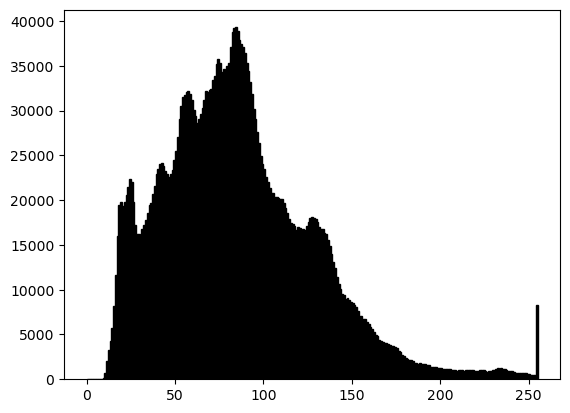

In [107]:
plot = plt.hist(im_mat.ravel(), bins=range(256), fc='k', ec='k')


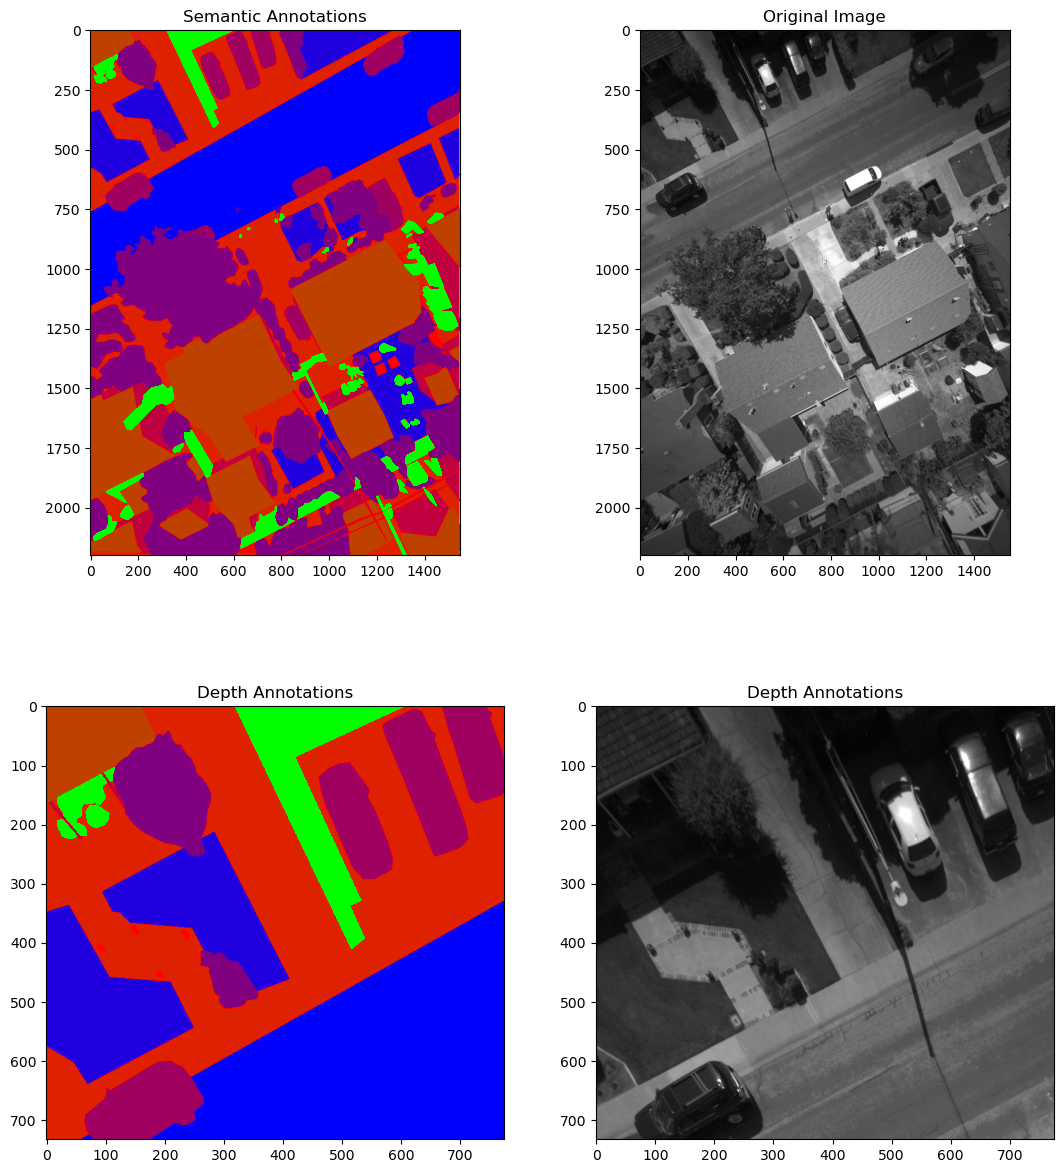

In [108]:
fig, ax = plt.subplots(2,2, figsize=(13,15))

ax[0,0].set_title('Semantic Annotations')
ax[0,1].set_title('Original Image')
ax[1,0].set_title('Depth Annotations')
ax[1,1].set_title('Depth Annotations')

x_len = im_mat.shape[1]
y_len = im_mat.shape[0]
ax[0,0].imshow(an_mat, cmap='brg', vmin=1, vmax=17)
ax[0,1].imshow(im_mat, cmap='gray')
ax[1,0].imshow(an_mat[:y_len//3, :x_len//2], cmap='brg', vmin=1, vmax=17)
ax[1,1].imshow(im_mat[:y_len//3, :x_len//2], cmap='gray')



plt.show()

## Notes1

- should all inputs be same size meaning when we subdivide them, do we do the same subdivision for each image 
- Or do we have different image sizes and use padding to adjust for size differences




In [99]:

d = 'inputs'
for file in os.listdir(d):
    im = Image.open(d + '/' + file)
    mat = np.array(im)
    if (mat.max() > 255) or (mat.min() < 0):
        print('error')
        

In [100]:
d = 'semantic_annotations'
for file in os.listdir(d):
    im = Image.open(d + '/' + file)
    mat = np.array(im)
    if (mat.max() > 255) or (mat.min() < 0):
        print('error')

In [101]:
d = 'semantic_annotations'
for file in os.listdir(d):
    im = Image.open(d + '/' + file)
    mat = np.array(im)
    mat[mat == 255] = 0
    if (mat.max() > 15):
        print('error')

There doesnt seem to be any issues with the data

UNET ARCHs:

- https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/
- https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py
- https://www.kaggle.com/code/balraj98/unet-for-building-segmentation-pytorch

Data Augmentations:
- https://pytorch.org/vision/main/auto_examples/plot_transforms.html#random-transforms


In [4]:
import torch 
import torchvision.transforms as T 


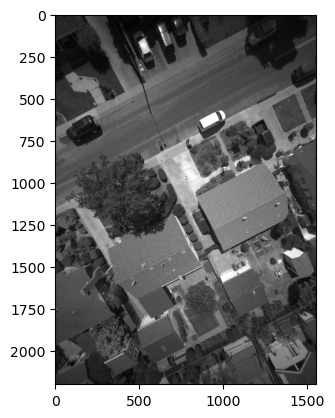

In [109]:
im_mat = np.array(im)
plt.imshow(im_mat, cmap='gray')



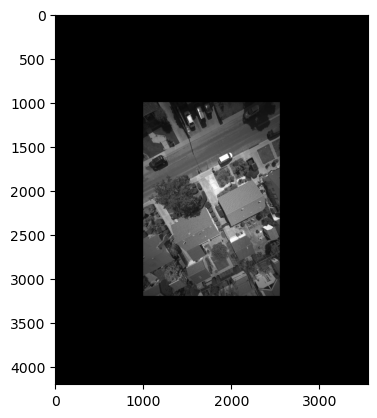

In [113]:
padded_im = T.Pad(padding=1000)(im)
padded_im_mat = np.array(padded_im)
plt.imshow(padded_im_mat, cmap='gray')

In [150]:
def plot_ims(im_list):
    n = len(im_list)
    fig, ax = plt.subplots(1,n, figsize=(17,15))
    for i in range(n):
        im_mat = np.array(im_list[i])
        ax[i].set_title(f'transformation {i}')
        
        ax[i].imshow(im_mat, cmap='gray')
        

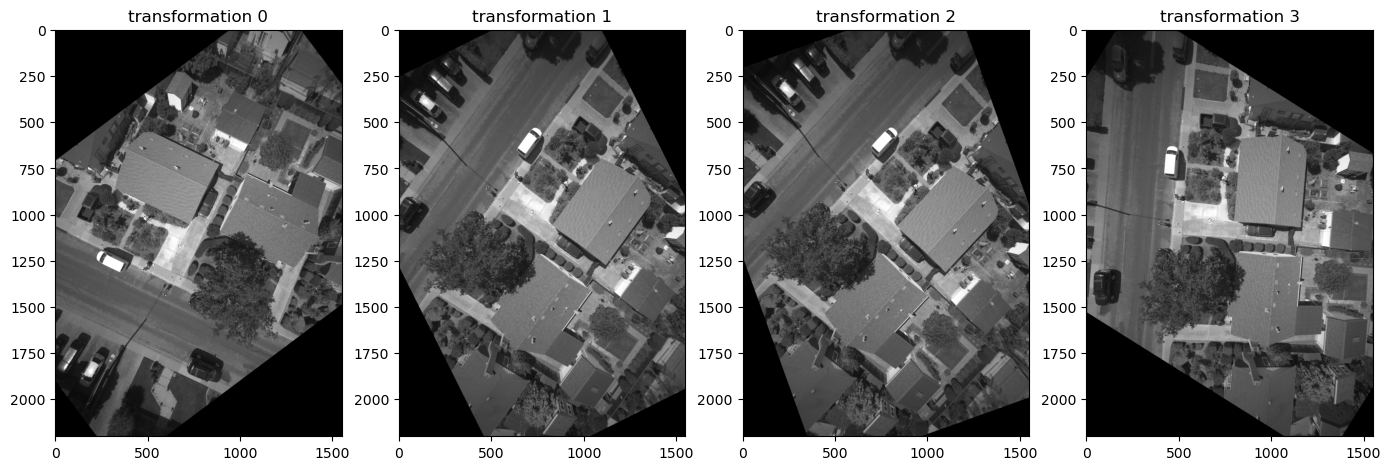

In [151]:
rotater = T.RandomRotation(degrees=(0, 180))
rotated_imgs = [rotater(im) for _ in range(4)]
plot_ims(rotated_imgs)


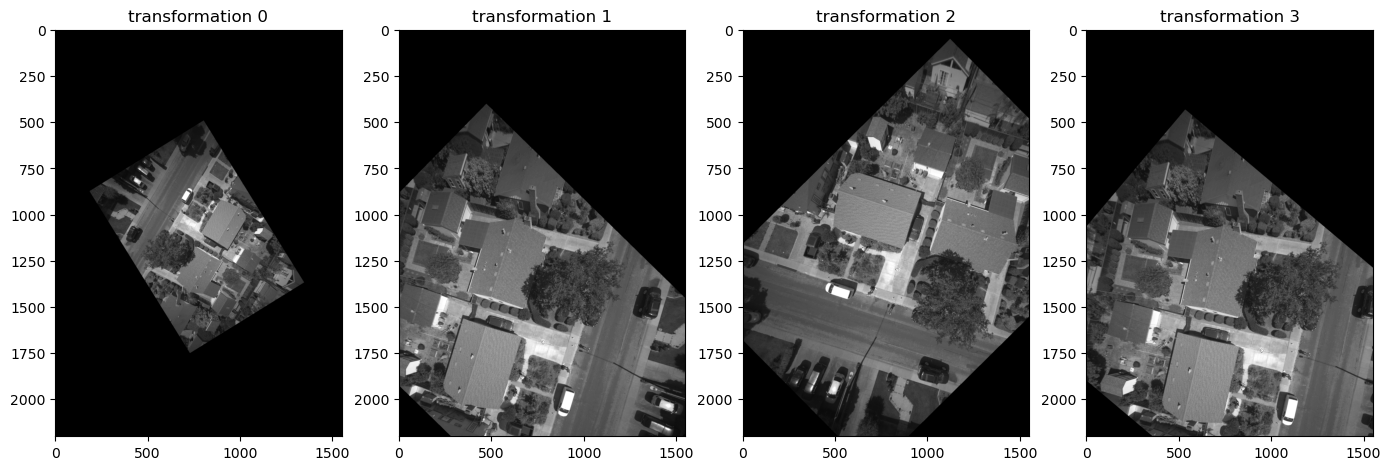

In [152]:
affine_transfomer = T.RandomAffine(degrees=(0, 360), translate=(0.1, 0.3), scale=(0.1, 1))
affine_imgs = [affine_transfomer(im) for _ in range(4)]
plot_ims(affine_imgs)


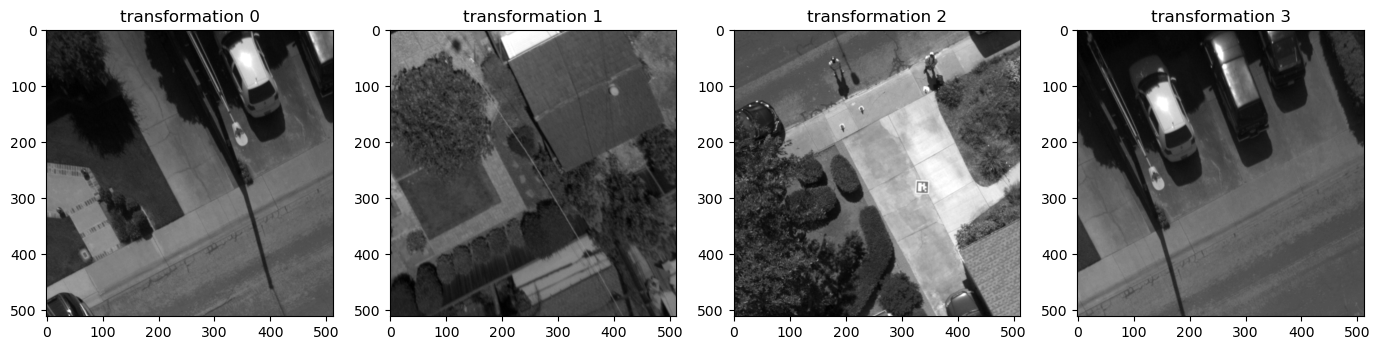

In [153]:
cropper = T.RandomCrop(size=(512, 512))
crops = [cropper(im) for _ in range(4)]
plot_ims(crops)

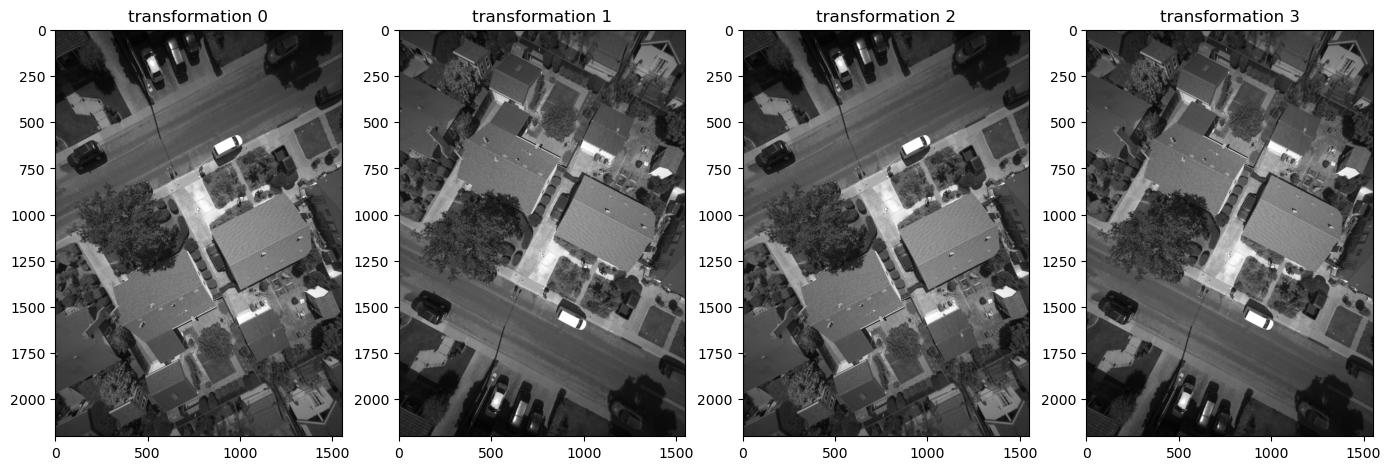

In [154]:
vflipper = T.RandomVerticalFlip(p=0.5)
transformed_imgs = [vflipper(im) for _ in range(4)]
plot_ims(transformed_imgs)

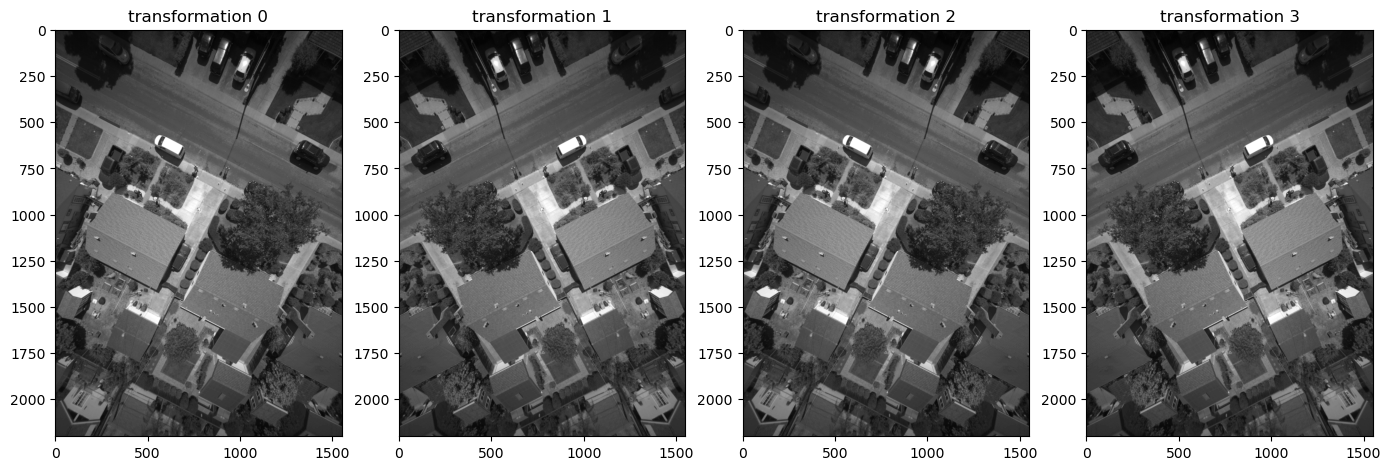

In [155]:
hflipper = T.RandomHorizontalFlip(p=0.5)
transformed_imgs = [hflipper(im) for _ in range(4)]
plot_ims(transformed_imgs)

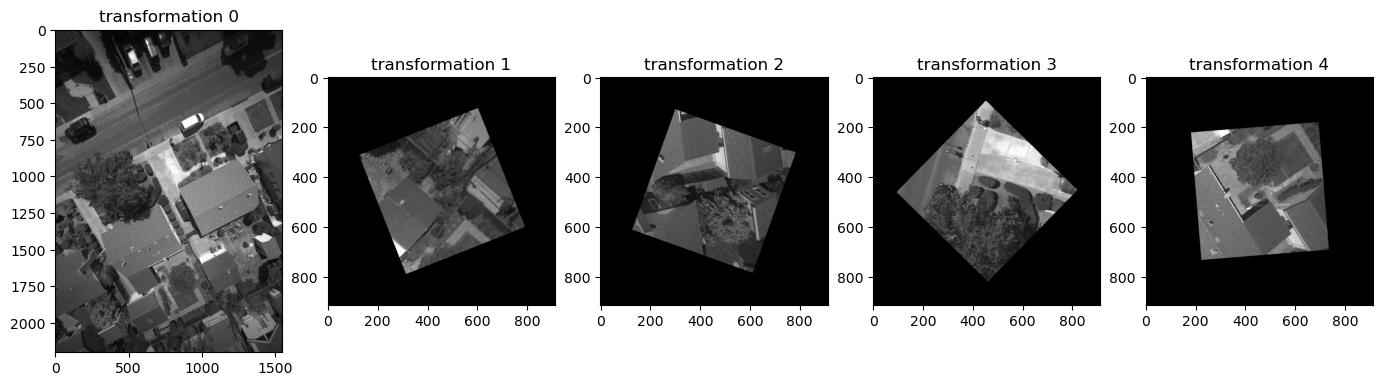

In [160]:
# compose transformations
transformation = torch.nn.Sequential(
    T.RandomCrop(size=(512, 512)), 
    T.Pad(padding=200),
    T.RandomRotation(degrees=(0, 180))
    )

transformed_imgs = [transformation(im) for _ in range(4)]
transformed_imgs = [im] + transformed_imgs
plot_ims(transformed_imgs)

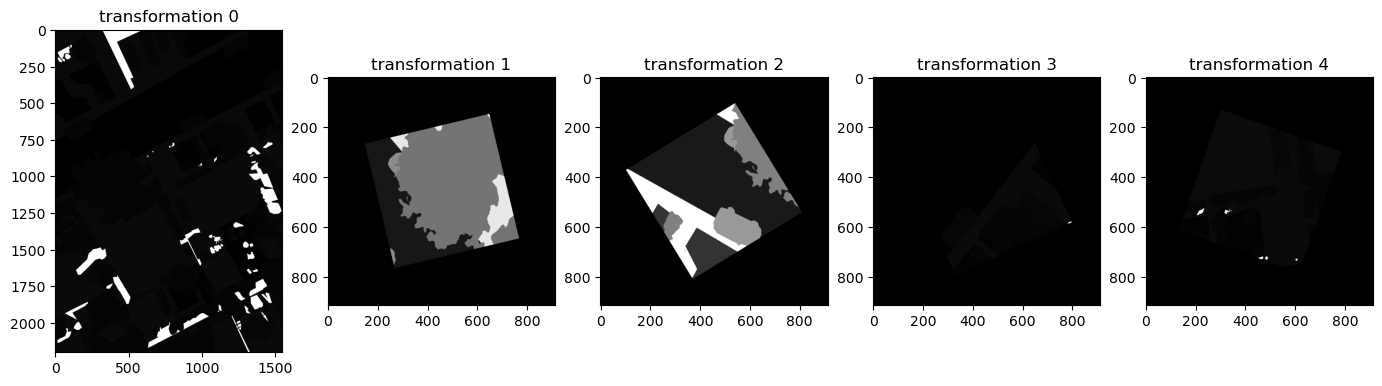

In [168]:
transformed_imgs = [transformation(an) for _ in range(4)]
transformed_imgs = [an] + transformed_imgs
plot_ims(transformed_imgs)

In [1]:
import torchvision.transforms.functional as TF
from torchvision import datasets
from torch.utils.data import Dataset
import random

In [61]:
class MyDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):
        self.image_files = os.listdir('test_in_dir/')
        self.target_files = os.listdir('test_mask_dir/')
        self.image_path = image_paths
        self.target_path = target_paths

    def transform(self, image, mask):
        # Resize
        resize = T.Resize(size=(2200, 1550))
        image = resize(image)
        mask = resize(mask)

        # Random crop
        if random.random() > 0.5:
            i, j, h, w = T.RandomCrop.get_params(
                image, output_size=(512, 512))
            image = TF.crop(image, i, j, h, w)
            mask = TF.crop(mask, i, j, h, w)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # # Transform to tensor
        # image = TF.to_tensor(image)
        # mask = TF.to_tensor(mask)
        return image, mask

    def __getitem__(self, index):
        print(self.target_files[index])
        image = Image.open(self.image_path + self.image_files[index])
        mask = Image.open(self.target_path + self.target_files[index])
        x, y = self.transform(image, mask)
        return x, y
        

    def __len__(self):
        return len(self.image_paths)

test_seman.png


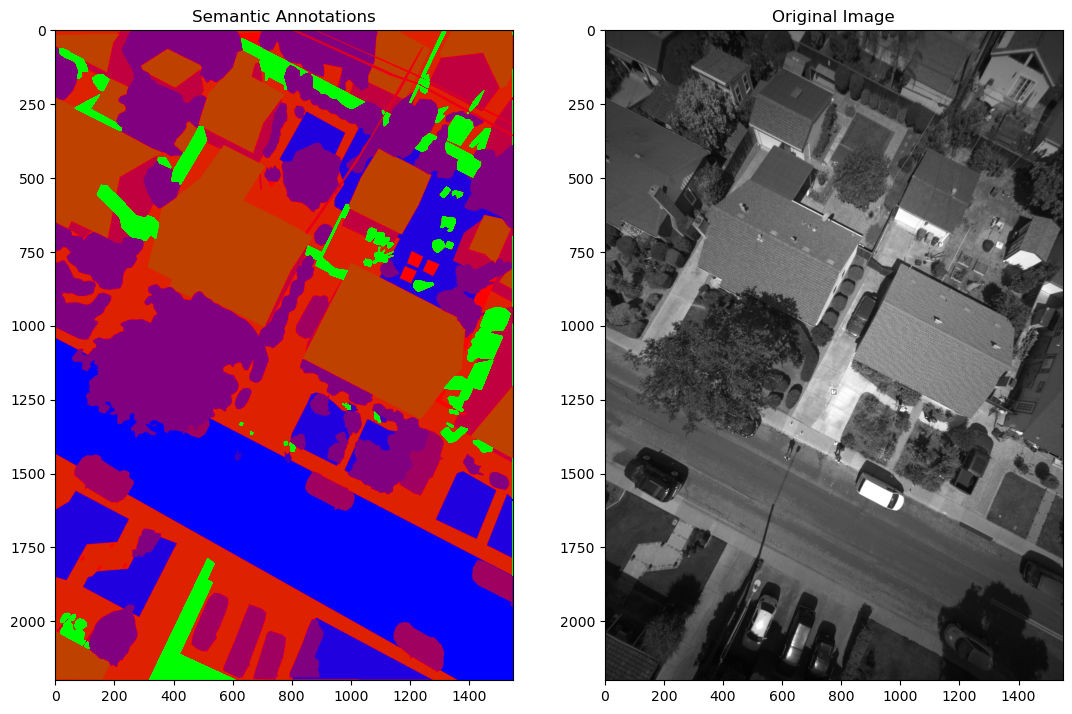

In [65]:
im_path = 'test_in_dir/'
mask_path = 'test_mask_dir/'

ds = MyDataset(im_path, mask_path)

x, y = ds.__getitem__(0)
im_mat = np.array(x)
an_mat = np.array(y)

fig, ax = plt.subplots(1,2, figsize=(13,15))

ax[0].set_title('Semantic Annotations')
ax[1].set_title('Original Image')


ax[0].imshow(an_mat, cmap='brg', vmin=1, vmax=17)
ax[1].imshow(im_mat, cmap='gray')



plt.show()
